In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from matplotlib.colors import BoundaryNorm, ListedColormap
from skimage import exposure

import seabeepy as sb
from seabeepy.config import SETTINGS

In [2]:
# Login to MinIO
client = sb.storage.minio_login(
    user=SETTINGS.MINIO_ACCESS_ID, password=SETTINGS.MINIO_SECRET_KEY
)

# Calculate NDVI

Calculating NDVI for Mathias' MSI missions (linked to the SABICAS project).

In [3]:
def calculate_ndvi(nir, red):
    ndvi = (nir - red) / (nir + red)

    return ndvi


def create_ndvi_colormap():
    colors = ["brown", "orange", "yellow", "green"]
    cmap = ListedColormap(colors)
    bounds = [-1, 0, 0.33, 0.66, 1]
    norm = BoundaryNorm(bounds, cmap.N)

    return cmap, norm


def equalize_histogram(image):
    equalized_image = np.empty_like(image)
    for i in range(image.shape[2]):
        equalized_image[:, :, i] = exposure.equalize_hist(image[:, :, i])

    return equalized_image

## 1. Datasets to process

Mathias has provided a list of MSI datasets to be processed. Some of them have issues that need to be resolved. The code below skips them for now.

In [4]:
# Read list of datasets from Mathias
ds_list_xlsx = r"../data/mathias_msi_missions.xlsx"
ds_df = pd.read_excel(ds_list_xlsx)

# Only process the ones wihtout data issues
ds_df = ds_df.query("comment == 'OK'").reset_index(drop=True)

ds_df

,flight,minio_folder,mosaic_name,comment
0,H20,niva-tidy/2023/niva_202308301136_halden_h20_ms...,niva-sabicas_halden-h20_202308301136_msi_80m,OK
1,H21,niva-tidy/2023/niva_202308301118_halden_h21_ms...,niva-sabicas_halden-h21_202308301118_msi_80m,OK
2,H22,niva-tidy/2023/niva_202308300752_halden_h22_ms...,niva-sabicas_halden-h22_202308300752_msi_80m,OK
3,H23,niva-tidy/2023/niva_202308301044_halden_h23_ms...,niva-sabicas_halden-h23_202308301044_msi_80m,OK
4,H24,niva-tidy/2023/niva_202308291402_halden_h24_ms...,niva-sabicas_halden-h24_202308291402_msi_80m,OK
5,H25,niva-tidy/2023/niva_202308291309_halden_h25_ms...,niva-sabicas_halden-h25_202308291309_msi_80m,OK
6,H28,niva-tidy/2023/niva_202308291436_halden_h28_ms...,niva-sabicas_halden-h28_202308291436_msi_80m,OK
7,H29,niva-tidy/2023/niva_202308290959_halden_h29_ms...,niva-sabicas_halden-h29_202308290959_msi_80m,OK
8,H30,niva-tidy/2023/niva_202308291100_halden_h30_ms...,niva-sabicas_halden-h30_202308291100_msi_80m,OK
9,H31,niva-tidy/2023/niva_202308291138_halden_h31_ms...,niva-sabicas_halden-h31_202308291138_msi_80m,OK


## 2. Calculate NDVI and plot

For each dataset, the code below calculates the NDVI as

$$NDVI = \frac{NIR - Red}{NIR + Red}$$

The output NDVI grids are saved within the mission folders on MinIO within a subfolder called `ndvi`.

For each dataset, the code also produces plots showing (i) an RGB composite generated from the MSI data (displayed using histogram equalisation to enhance contrast), and (ii) the corresponding NDVI grid. As a starting point, the NDVI grid is displayed using the following classes:

 * **NDVI < 0:** *Brown*. No vegetation.
 * **0 ≤ NDVI < 0.33:** *Orange*. Low density/unhealthy vegetation.
 * **0.33 ≤ NDVI < 0.66:** *Yellow*. Medium density/moderately healthy vegetation.
 * **NDVI ≥ 0.66:** *Green*. High density/healthy vegetation.

In [5]:
# User options
equalise_rgb = True
png_path = r"../plots/rgb_ndvi_by_site.png"  # Set to None to skip saving plot

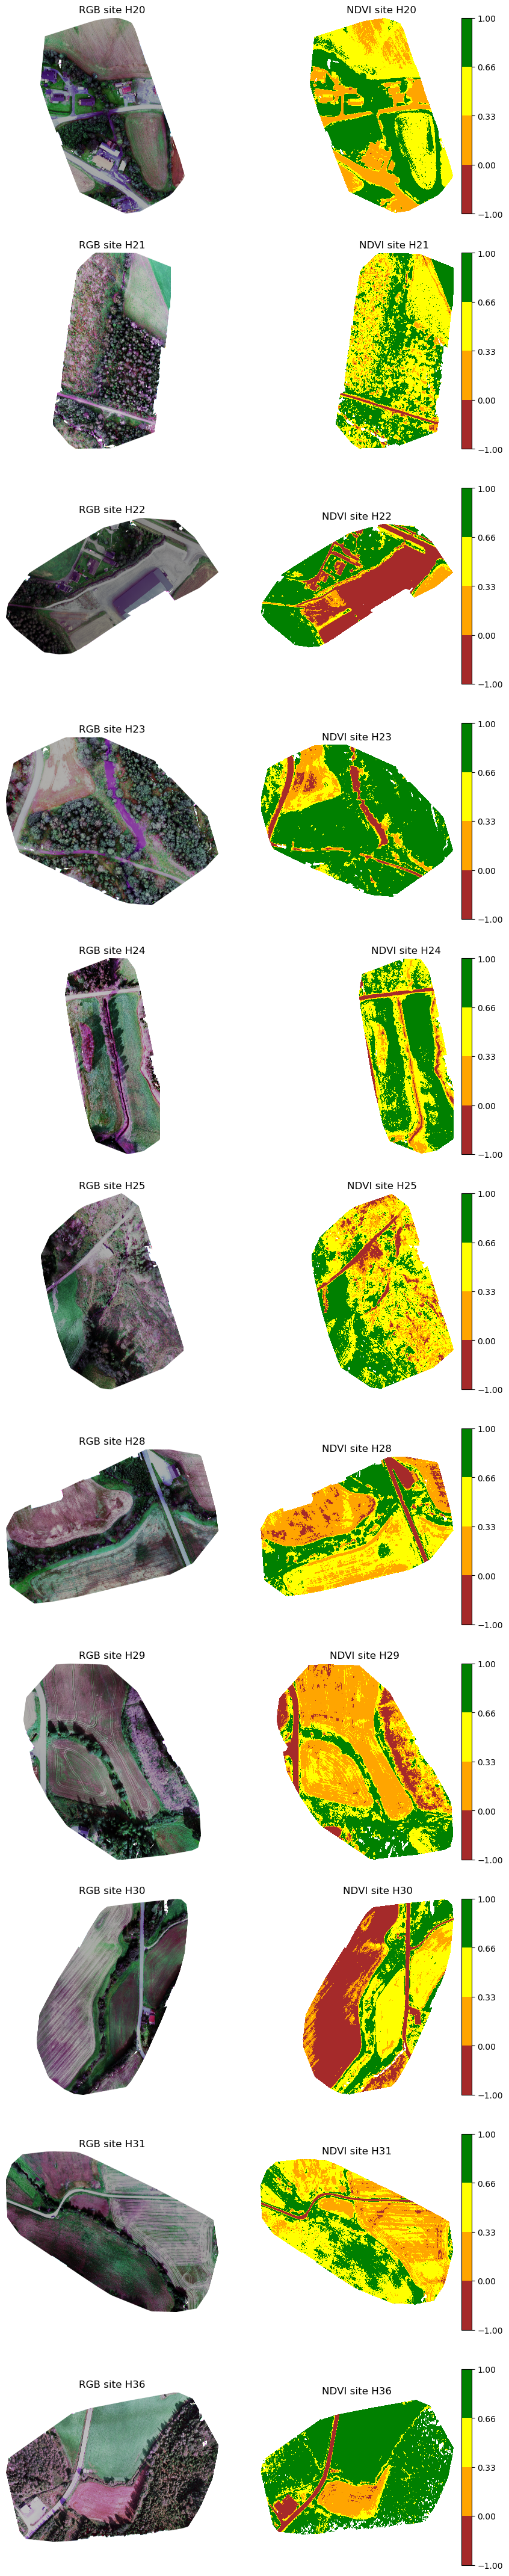

In [6]:
# Create a figure for the subplots
num_datasets = len(ds_df)
fig, axes = plt.subplots(num_datasets, 2, figsize=(10, 5 * num_datasets))

# Loop over datasets
for idx, row in ds_df.iterrows():
    folder = row["minio_folder"]
    name = row["mosaic_name"]
    site = row["flight"]
    ortho_tif_path = (
        f"/home/notebook/shared-seabee-ns9879k/{folder}/orthophoto/{name}.tif"
    )
    ndvi_tif_path = (
        f"/home/notebook/shared-seabee-ns9879k/{folder}/ndvi/{name}_ndvi.tif"
    )

    if not os.path.exists(ortho_tif_path):
        print(f"File does not exist: {ortho_tif_path}")
        continue

    with rasterio.open(ortho_tif_path) as src:
        # Read the band descriptions to find the indices of bands of interest
        band_descriptions = src.descriptions
        if len(band_descriptions) != 5:
            print(
                "Cannot determine band order for:\n"
                f"{ortho_tif_path}\n"
                f"{band_descriptions}"
            )
            continue

        nir_band_index = band_descriptions.index("nir") + 1
        red_band_index = band_descriptions.index("red") + 1
        green_band_index = band_descriptions.index("green") + 1
        blue_band_index = band_descriptions.index("blue") + 1

        nir = src.read(nir_band_index).astype(np.float32)
        red = src.read(red_band_index).astype(np.float32)
        green = src.read(green_band_index).astype(np.float32)
        blue = src.read(blue_band_index).astype(np.float32)

        nodata = src.nodata

        # Set NoData values to np.nan
        nir[nir == nodata] = np.nan
        red[red == nodata] = np.nan
        green[green == nodata] = np.nan
        blue[blue == nodata] = np.nan

        # Calculate NDVI
        ndvi = calculate_ndvi(nir, red)

        # Stack the RGB bands, set NoData to white, and normalize to range [0, 1]
        rgb = np.dstack((red, green, blue))
        rgb[np.isnan(rgb)] = 255
        rgb = rgb / 255

        if equalise_rgb:
            # Equalise histogram to enhance contrast
            rgb = equalize_histogram(rgb)

        # Plot the original RGB image
        axes[idx, 0].imshow(rgb)
        axes[idx, 0].set_title(f"RGB site {site}")
        axes[idx, 0].axis("off")

        # Plot the NDVI image
        cmap, norm = create_ndvi_colormap()
        cax = axes[idx, 1].imshow(ndvi, cmap=cmap, norm=norm)
        axes[idx, 1].set_title(f"NDVI site {site}")
        axes[idx, 1].axis("off")

        fig.colorbar(
            cax, ax=axes[idx, 1], orientation="vertical", fraction=0.05, pad=0.04
        )

        # Set NaNs in NDVI grid to the original NoData value
        ndvi[np.isnan(ndvi)] = nodata

        # Save NDVI grid locally
        ndvi_temp_path = f"{name}_ndvi.tif"
        meta = src.meta
        meta.update(
            driver="GTiff",
            dtype=rasterio.float32,
            count=1,
            nodata=nodata,
            compress="LZW",
        )
        with rasterio.open(ndvi_temp_path, "w", **meta) as dst:
            dst.write(ndvi.astype(rasterio.float32), 1)

        # Copy to MinIO and delete temp file
        sb.storage.copy_file(ndvi_temp_path, ndvi_tif_path, client, overwrite=True)
        os.remove(ndvi_temp_path)

if png_path:
    plt.savefig(png_path, dpi=200, bbox_inches="tight")